In [33]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import date_to_unix as date
import datetime
import itertools


In [34]:
# Initialize the Binance client
client = Client()

In [35]:
# UNIX timestamp 
start_date = date.date_to_unix('2019-09-10 00:00:00')

In [36]:


# UNIX timestamp for today's midnight
today_midnight = datetime.datetime.combine(datetime.date.today(), datetime.time())

today_midnight_unix = date.date_to_unix(today_midnight.strftime('%Y-%m-%d %H:%M:%S'))

all_funding_df = pd.DataFrame()
funding_df=pd.DataFrame()
funding_rates = []

while True:
    # Query the futures funding rates
    funding_rates = client.futures_funding_rate(symbol='ETHUSDT', startTime = start_date, limit=1000)

    # Convert to DataFrame
    funding_df = pd.DataFrame(funding_rates)
    funding_df['fundingTime'] = pd.to_datetime(funding_df['fundingTime'], unit='ms').dt.round('s')
    funding_df.set_index('fundingTime', inplace=True)
    
    # Concatenate the newly fetched data with the accumulated data
    all_funding_df = pd.concat([all_funding_df, funding_df])

    # Get the last date in the fetched data
    last_date = funding_df.index[-1]

    if last_date >= pd.to_datetime(today_midnight_unix, unit='s'):
        break
    else:
        # Set start_date to the last fetched timestamp in UNIX format for the next query iteration
        start_date = int(last_date.timestamp() * 1000)  # Convert to milliseconds for Binance API

# You now have your data collected in funding_df up to today's midnight
print(all_funding_df)
print(funding_rates)

                      symbol  fundingRate      markPrice
fundingTime                                             
2019-11-27 08:00:00  ETHUSDT   0.00010000               
2019-11-27 16:00:00  ETHUSDT   0.00010000               
2019-11-28 00:00:00  ETHUSDT   0.00010000               
2019-11-28 08:00:00  ETHUSDT   0.00001401               
2019-11-28 16:00:00  ETHUSDT  -0.00010610               
...                      ...          ...            ...
2024-05-15 00:00:00  ETHUSDT   0.00010000  2880.87000000
2024-05-15 08:00:00  ETHUSDT   0.00008171  2914.65150758
2024-05-15 16:00:00  ETHUSDT   0.00009162  2976.66000000
2024-05-16 00:00:00  ETHUSDT   0.00010000  3030.87753030
2024-05-16 08:00:00  ETHUSDT   0.00006453  3015.12305303

[4901 rows x 3 columns]
[{'symbol': 'ETHUSDT', 'fundingTime': 1689926400000, 'fundingRate': '0.00000473', 'markPrice': ''}, {'symbol': 'ETHUSDT', 'fundingTime': 1689955200000, 'fundingRate': '0.00007376', 'markPrice': ''}, {'symbol': 'ETHUSDT', 'fundingTime'

In [37]:
funding_df= all_funding_df

print(funding_df.shape)
print(funding_df.dtypes)

(4901, 3)
symbol         object
fundingRate    object
markPrice      object
dtype: object


In [38]:
#Give correct type
funding_df['fundingRate'] = funding_df['fundingRate'].astype(float)
funding_df['symbol'] = funding_df['symbol'].astype(str)
funding_df['markPrice'] = pd.to_numeric(funding_df['markPrice'], errors='coerce')
print(funding_df.head())
print(funding_df.tail())
print(funding_df.describe())


                      symbol  fundingRate  markPrice
fundingTime                                         
2019-11-27 08:00:00  ETHUSDT     0.000100        NaN
2019-11-27 16:00:00  ETHUSDT     0.000100        NaN
2019-11-28 00:00:00  ETHUSDT     0.000100        NaN
2019-11-28 08:00:00  ETHUSDT     0.000014        NaN
2019-11-28 16:00:00  ETHUSDT    -0.000106        NaN
                      symbol  fundingRate    markPrice
fundingTime                                           
2024-05-15 00:00:00  ETHUSDT     0.000100  2880.870000
2024-05-15 08:00:00  ETHUSDT     0.000082  2914.651508
2024-05-15 16:00:00  ETHUSDT     0.000092  2976.660000
2024-05-16 00:00:00  ETHUSDT     0.000100  3030.877530
2024-05-16 08:00:00  ETHUSDT     0.000065  3015.123053
       fundingRate    markPrice
count  4901.000000   595.000000
mean      0.000167  2723.742736
std       0.000324   592.284250
min      -0.003563  1791.039903
25%       0.000055  2241.082956
50%       0.000100  2538.170000
75%       0.000100  

In [39]:
# Fetch historical price data for ETHUSDT spot and future
klines = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))
klines_future= client.futures_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))

In [40]:
def klines_toDf(klines):
    """
    Convert list of klines to a pandas DataFrame.

    :param klines: A list of klines data.
    :type klines: list
    :return: A pandas DataFrame with columns ['Open Time', 'Open', 'Close', 'Volume'].
    :rtype: pandas.DataFrame
    """
    prices_df = pd.DataFrame(klines, columns=[
        'Open Time', 
        'Open', 
        'High', 
        'Low', 
        'Close', 
        'Volume', 
        'Close Time', 
        'Quote Asset Volume', 
        'Number of Trades', 
        'Taker Buy Base Asset Volume', 
        'Taker Buy Quote Asset Volume', 
        'Ignore'
    ])
    
    prices_df = prices_df[['Open Time', 'Open', 'Close', 'Volume']]
    
    # Convert time from milliseconds to a readable date format
    prices_df['Open Time'] = pd.to_datetime(prices_df['Open Time'], unit='ms')
    prices_df.set_index('Open Time', inplace=True)
    # Convert 'Open', 'Close', and 'Volume' to float
    prices_df['Open'] = prices_df['Open'].astype(float)
    prices_df['Close'] = prices_df['Close'].astype(float)
    prices_df['Volume'] = prices_df['Volume'].astype(float)
    
    # Now apply rounding
    prices_df = prices_df.round(decimals=4)
    
    # Check the changes
    print(prices_df.head())
    print(prices_df.tail())
    print(prices_df.dtypes)
    print(prices_df.shape)
    return prices_df

In [41]:
# Convert the spot and future kline data to dataframes
price_df_spot = klines_toDf(klines)
price_df_futur = klines_toDf(klines_future)

# Rename the 'Open' column in both dataframes for clarity
price_df_spot = price_df_spot.rename(columns={'Open': 'Open ETHUSDT_SPOT'})
price_df_futur = price_df_futur.rename(columns={'Open': 'Open ETHUSDT_PERP'})

# Concatenate the two dataframes along the column axis
prices_df = pd.concat([price_df_spot['Open ETHUSDT_SPOT'], price_df_spot['Volume'], price_df_futur['Open ETHUSDT_PERP'], price_df_futur['Volume']], axis=1)
prices_df.columns = ['Open ETHUSDT_SPOT', 'Volume ETH_SPOT', 'Open ETHUSDT_PERP', 'Volume ETH_PERP']

# Display the resulting dataframe
prices_df

                       Open   Close       Volume
Open Time                                       
2019-11-27 08:00:00  146.28  150.65  261979.0822
2019-11-27 16:00:00  150.67  152.62  167147.1863
2019-11-28 00:00:00  152.61  152.21   98660.8611
2019-11-28 08:00:00  152.23  153.99  137091.4392
2019-11-28 16:00:00  153.97  150.72   81962.2629
                        Open    Close       Volume
Open Time                                         
2024-05-15 00:00:00  2881.93  2916.51   55593.3085
2024-05-15 08:00:00  2916.50  2976.81  183981.6888
2024-05-15 16:00:00  2976.80  3032.55  110679.3215
2024-05-16 00:00:00  3032.55  3016.31   89492.9592
2024-05-16 08:00:00  3016.31  2993.90   52021.5779
Open      float64
Close     float64
Volume    float64
dtype: object
(4897, 3)
                       Open   Close     Volume
Open Time                                     
2019-11-27 08:00:00  125.03  150.65  46764.630
2019-11-27 16:00:00  150.72  152.52  69147.200
2019-11-28 00:00:00  154.29  151.9

,Open ETHUSDT_SPOT,Open ETHUSDT_PERP
Open Time,,
2019-11-27 08:00:00,146.28,125.03
2019-11-27 16:00:00,150.67,150.72
2019-11-28 00:00:00,152.61,154.29
2019-11-28 08:00:00,152.23,152.04
2019-11-28 16:00:00,153.97,153.78
...,...,...
2024-05-15 00:00:00,2881.93,2880.87
2024-05-15 08:00:00,2916.50,2914.56
2024-05-15 16:00:00,2976.80,2975.54


In [42]:
#Merge the prices with the funding and Mark price
data2 = pd.concat([prices_df,funding_df['fundingRate'],funding_df['markPrice']],axis=1)
data2['cumulative funding rate'] = data2['fundingRate'].cumsum()
data2.index.name = 'Open Time'

In [43]:
data2.shape

(4901, 5)

In [44]:
data2.tail()


,Open ETHUSDT_SPOT,Open ETHUSDT_PERP,fundingRate,markPrice,cumulative funding rate
Open Time,,,,,
2024-05-15 00:00:00,2881.93,2880.87,0.000100,2880.870000,0.817985
2024-05-15 08:00:00,2916.50,2914.56,0.000082,2914.651508,0.818067
2024-05-15 16:00:00,2976.80,2975.54,0.000092,2976.660000,0.818158
2024-05-16 00:00:00,3032.55,3030.67,0.000100,3030.877530,0.818258
2024-05-16 08:00:00,3016.31,3015.07,0.000065,3015.123053,0.818323


In [45]:
data2.describe()

,Open ETHUSDT_SPOT,Open ETHUSDT_PERP,fundingRate,markPrice,cumulative funding rate
count,4901.000000,4901.000000,4901.000000,595.000000,4901.000000
mean,1787.881753,1787.931326,0.000167,2723.742736,0.528612
std,1142.275901,1142.530497,0.000324,592.284250,0.241967
min,107.020000,106.970000,-0.003563,1791.039903,-0.000344
25%,1050.190000,1049.900000,0.000055,2241.082956,0.313593
50%,1762.060000,1760.770000,0.000100,2538.170000,0.662163
75%,2535.860000,2535.080000,0.000100,3200.615527,0.689730
max,4846.940000,4850.950000,0.003750,4070.520000,0.818323


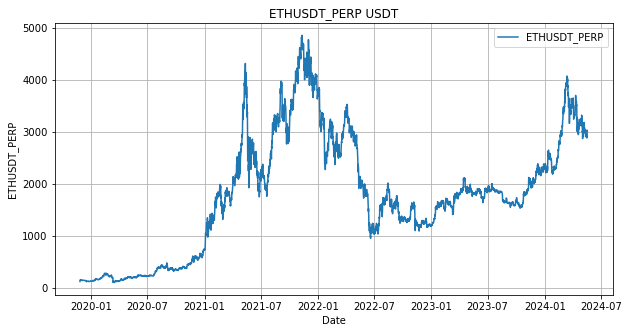

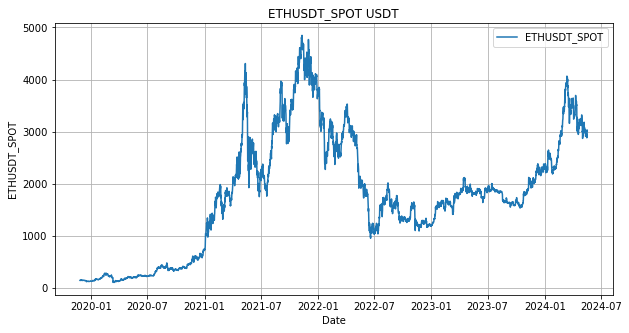

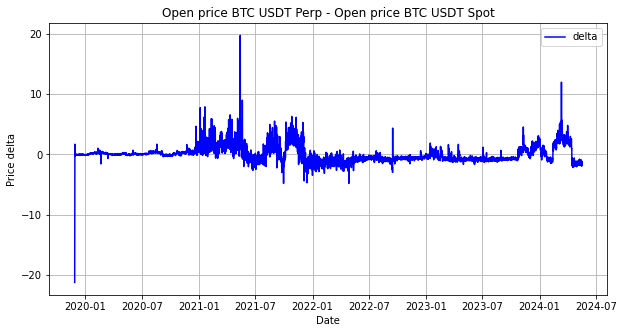

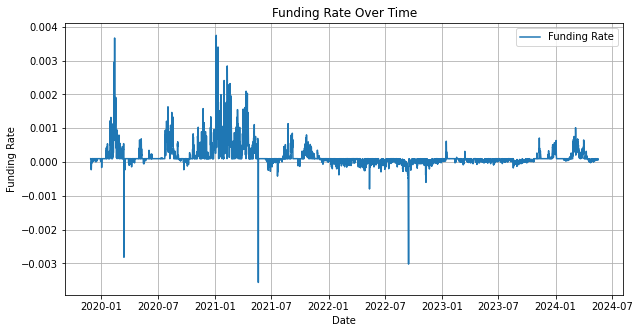

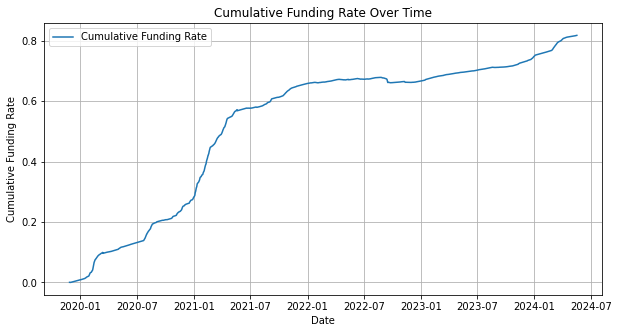

In [46]:
# Plotting ETHUSDT_PERP prices
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['Open ETHUSDT_PERP'],label = 'ETHUSDT_PERP')
plt.title('ETHUSDT_PERP USDT')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('ETHUSDT_PERP')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

# Plotting ETHUSDT_SPOT prices
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['Open ETHUSDT_SPOT'],label = 'ETHUSDT_SPOT')
plt.title('ETHUSDT_SPOT USDT')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('ETHUSDT_SPOT')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

#Plotting the price difference between Future and Spot on Binance perpetual 
plt.figure(figsize=(10, 5))
plt.plot(prices_df.index, prices_df['Open ETHUSDT_PERP']-prices_df['Open ETHUSDT_SPOT'], color='blue', label= 'delta')
plt.title('Open price ETH USDT Perp - Open price ETH USDT Spot')
plt.xlabel('Date')
plt.ylabel('Price delta')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['fundingRate'], label='Funding Rate')
plt.title('Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

# Plotting the cumulative funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['cumulative funding rate'], label='Cumulative Funding Rate')
plt.title('Cumulative Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Cumulative Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend
plt.show()  # Display the plot


In [47]:
data2

,Open ETHUSDT_SPOT,Open ETHUSDT_PERP,fundingRate,markPrice,cumulative funding rate
Open Time,,,,,
2019-11-27 08:00:00,146.28,125.03,0.000100,NaN,0.000100
2019-11-27 16:00:00,150.67,150.72,0.000100,NaN,0.000200
2019-11-28 00:00:00,152.61,154.29,0.000100,NaN,0.000300
2019-11-28 08:00:00,152.23,152.04,0.000014,NaN,0.000314
2019-11-28 16:00:00,153.97,153.78,-0.000106,NaN,0.000208
...,...,...,...,...,...
2024-05-15 00:00:00,2881.93,2880.87,0.000100,2880.870000,0.817985
2024-05-15 08:00:00,2916.50,2914.56,0.000082,2914.651508,0.818067
2024-05-15 16:00:00,2976.80,2975.54,0.000092,2976.660000,0.818158


In [48]:
data2.to_csv('data\ETH 2019-09-10')